## Import the list of tools ##

In [1]:
from utils import *

iminuit version: 2.31.1


## The expression below gives the cross section of the processes $e^{+}e^{-}\rightarrow  \mu^+\mu^-$, as a function of the centre of mass energy $\sqrt{s}$. The parameters $m_{Z}$, $\Gamma_{Z}$ denote the mass and width of the $Z^0$ boson respectively ##

$$\sigma(e^{+}e^{-}\rightarrow  \mu^+\mu^-) = \frac{12\pi s}{m_{Z}^{2}}\frac{\Gamma_{e^+e^-}\Gamma_{\mu^+\mu^-}}{(s-m_{Z}^{2})^{2}+m_{Z}^{2}\Gamma_{Z}^{2}}$$

# Question 1 [4 marks] #

- What is the key assumption that goes into the expression above?
- What is the physical meaning of $\Gamma_{e^+e^-}$ and $\Gamma_{\mu^+\mu^-}$?


<div style="background-color: lightblue; padding: 10px; border-radius: 5px;">
<h3> Answer 1 </h3> 

 - [2 marks] For the expression to hold, we need to be in an energy regime that is dominated by the $Z^0$ interaction over the photon interaction. That means at a $\sqrt{s}\gg 10$GeV .</span>

 - [2 marks]  $\Gamma_{ee}$ and $\Gamma_{\mu\mu}$ denote the partial widths of the $Z^0\to e^+e^-$ and $Z^0\to \mu^+\mu^-$ respectively

</div>

# Task A: Make sure you can follow the code snippet below and ask any questions at drop-in sessions #

## A Python function that returns a numerical value of the aforementioned cross-section $\sigma(e^{+}e^{-}\rightarrow  \mu^+\mu^-)$ is shown below: ##

In [2]:
def sigma_ee_mm(x,mZ_var,gZ_var,gee_var,gmm_var):
    s = x**2
    mZsq_var = mZ_var**2
    sigma = np.pi*s*gee_var*gmm_var/(mZsq_var*(s-mZsq_var)**2+mZsq_var*gZ_var**2)
    return sigma

# Task B: Make sure you can follow and execute the code snippet below and ask any questions at drop-in sessions #

## The snippet below plots the cross section as a function of $\sqrt{s}$: ## 

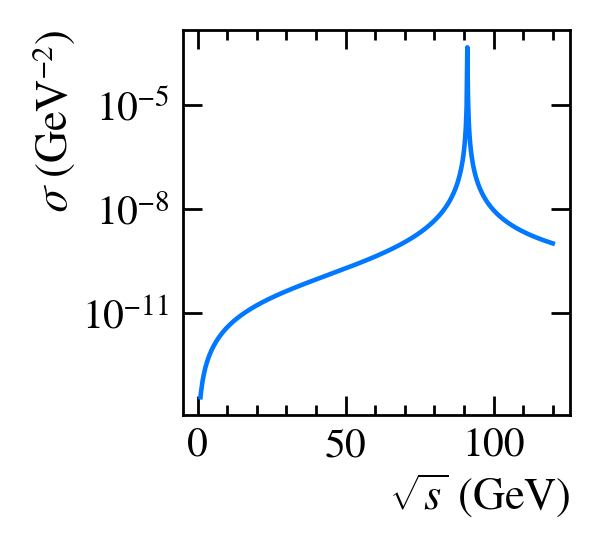

In [3]:
mZ, gZ = 91.18, 2.496   # in GeV 
gee, gmm = 0.084, 0.084 # in GeV
sqrts = np.linspace(1,120,500)
xsec = sigma_ee_mm(sqrts,mZ,gZ,gee,gmm)
plt.figure(figsize=(5,5)) 
plt.tight_layout()
plt.yscale('log')
plt.plot(sqrts,xsec)
plt.xlabel("$\sqrt{s}$ (GeV)")
plt.ylabel("$\sigma$ ($\mathrm{GeV}^{-2})$")
plt.show()

# Question 2 [8 marks] #
- Explain how we arrived at the values of the parameters "gee_val" and "gmm_val" given in the cell above. You are given that $\rm{BF(Z^0\to e^+e^-)} = \rm{BF(Z^0\to \mu^+\mu^-)} = 3.366\%$ 
- The plot above shows the cross-section drop at around 1GeV. Is this effect physical? Explain your reasoning. 

<div style="background-color: lightblue; padding: 10px; border-radius: 5px;">
<h3> Answer 2 </h3> 

- [2 marks] $\Gamma_{e^+e^-} = \Gamma_{Z}\times \rm{BF(Z^0\to e^+e^-)}$ and $\Gamma_{\mu^+\mu^-} = \Gamma_{Z}\times \rm{BF(Z^0\to \mu^+\mu^-)}$. Therefore, $\Gamma_{e^+e^-}=\Gamma_{\mu^+\mu^-}=0.084$GeV

- [6 marks] The effect is not physical. It is because of the assumption that only the $Z^0$ contribution is included in the expression of the $e^+e^-\to \mu^+\mu^-$ interaction cross-section. In reality, there is the contribution from the photon which dominates at lower $\sqrt{s}$ values far from the $Z^0$ peak, and in fact exhibits a $\displaystyle\frac{1}{s}$ dependence due to the Feynman rule of the photon propagator givng rise to an increase in the cross-section as the CoM energy decreases, instead of the drop seen in the plot above.


# Question 3 [8 marks] #
- Which parameter would you modify in the expression of the cross section given above in order to describe the process $e^+e^- \to\mathrm{hadrons}$?
- What would be the telling signature of $e^+e^- \to Z^{0}\to\mathrm{q\bar{q}}$ where $q$ denotes a quark?  
- For an onshell $Z^0$ boson, what quark pairs can the $Z^0$ decay into?



<div style="background-color: lightblue; padding: 10px; border-radius: 5px;">
<h3>Answer 3 [8 marks]</h3> 

- [2 marks] Need to replace $\Gamma_{\mu^+\mu^-}$ with $\Gamma_{q\bar{q}}$
    
- [4 marks] Since a quark anti-quark pair is produced, the telling signature woulbe be a pair of hadron jets
   
- [2 marks] To produce a quark anti=quark pair requires at least $2m_{q}$ amount of CoM energy. This means given that an on-shell $Z^0$ is at $\sim 91$GeV, we can produce $u\bar{u}$, $d\bar{d}$, $c\bar{c}$, $s\bar{s}$, $b\bar{b}$ but do not have enough energy to produce $t\bar{t}$.

</div>

# Task C: Make sure you can follow and execute the code snippet below and ask any questions at drop-in sessions #


## The cell below shows an example of how to generate some data according to the cross-section function given above, and then plotting a histogram of the generated values ## 

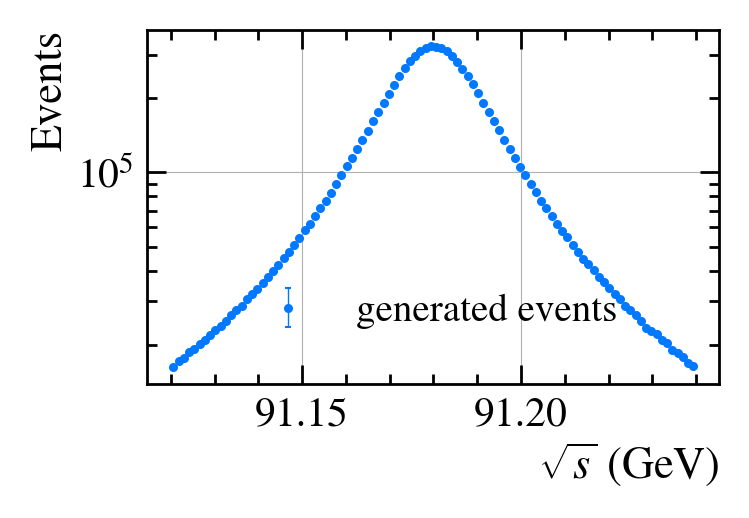

In [4]:
# Generate 10000000 values of sqrts according to the expression of the cross-section function defined
# earlier for CoM energies between sqrts_min and sqrts_max.
sqrts_min = 91.12
sqrts_max = 91.24
n_events = 10000000
sqrts_vals = gen_data(n_events,sigma_ee_mm,x_min=sqrts_min,x_max=sqrts_max,
                      mZ_var=mZ,gZ_var=gZ,gee_var=gee,gmm_var=gmm)

# Plot a histogram of the data we just generated
hist, bin_edges = np.histogram(sqrts_vals, bins=100)
errors = np.sqrt(hist)

fig, ax = plt.subplots(figsize=(8,5))
hep.histplot(hist,bins=bin_edges,
    histtype="errorbar",yerr=errors,
    label="generated events",
    color="C0",ax=ax
)
ax.set_xlabel("$\sqrt{s}$ (GeV)")
ax.set_ylabel("Events")
ax.legend()
fig.tight_layout()
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.show()

# Task D: Make sure you can follow and execute the code snippet below and ask any questions at drop-in sessions #


## The cell below shows an example of how to create a cumulative distribution probability density function out of the cross-section function and feed it to a minimisation algorithm together with the generated data to determine $\Gamma_Z$


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 97.04 (χ²/ndof = 1.0)      │              Nfcn = 69               │
│ EDM = 7.25e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───

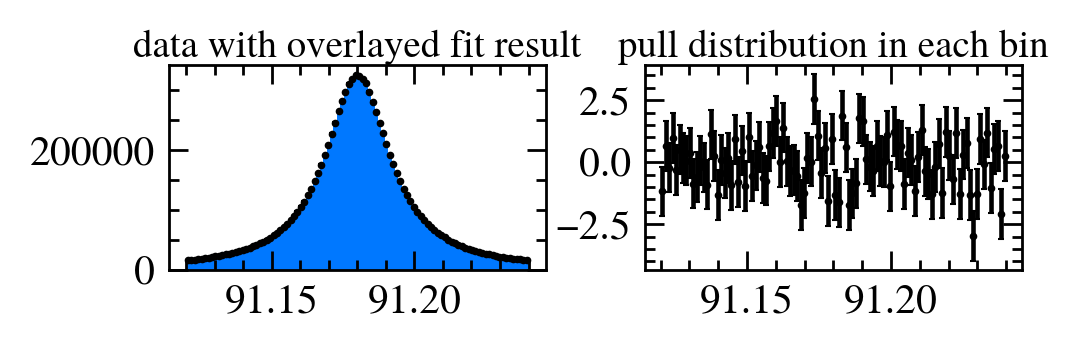

In [5]:
'''
The minimisation algorithm takes in the `toy` data we created in the previous cell, along with
the cdf function defined below and performs a fit to estimate the Z width, gZ, using a so-called
binned negative log-likelihood cost function. We then print the result table as well as make
a plot of the histogram and its fitted distribution
'''

# wrapper function of cross-section function that computes cdf to pass to minimiser
# TLDR: can replace the sigma_ee_mm function with ANY function you like
def sigma_ee_mm_cdf(bin_edges, *params):
    return func_cdf(sigma_ee_mm, bin_edges, *params)

# the parameters that the function depends on (need to match those appearing
# in the function all the way at the top of this notebook
names = ["mZ_var", "gZ_var", "gee_var", "gmm_var"]

# create the cost function to minimise to determine the parameters
# TLDR: can replace the sigma_ee_mm function with ANY function you like
cost = BinnedNLL(hist, bin_edges, sigma_ee_mm_cdf,name=names)

# Initialises the minimisation algorithm and takes starting values of the parameters we are fitting for
m = Minuit(cost, mZ_var=91.15,gZ_var=2,gee_var=0.084,gmm_var=0.084) 
m.fixed['gee_var']=True  # we only want to determine mZ, gZ so keep gee fixed to its actual value
m.fixed['gmm_var']=True  # we only want to determine mZ, gZ so keep gmm fixed to its actual value
m.print_level = 0
migrad = m.migrad() # finds minimum of binned negative log likelihood function
hesse  = m.hesse()   # accurately computes uncertainties
print(hesse)      # print the fit result  


# visualise the result of the fit. The points are the original histogrammed values 
# and the blue histogram represents the binned function resulting from the fit to the histogram.
pred    = cost.prediction(m.values)
fig, ax = plt.subplots(1,2,figsize=(10, 3), constrained_layout=True)
plt.sca(ax[0])
plt.title("data with overlayed fit result")
cx = 0.5*(bin_edges[1:]+bin_edges[:-1])
plt.errorbar(cx,hist, errors, fmt="ok",markersize=4)
plt.stairs(pred, bin_edges, fill=True)

# the pull is defined for each histogram bin as: (N_{predicted}-N_{observed})/\sigma_{predicted}
pulls    = cost.pulls(m.values)
plt.sca(ax[1])
plt.title("pull distribution in each bin")
plt.errorbar(cx, pulls, 1, fmt="ok",markersize=4);

# Question 4 [80 marks] #
- Devise an approach to determine the number of generations of neutrinos by performing a fit to the histogram created out of the "toy" $e^+e^-$ dataset provided in the previous cell
    - You are given that in the SM: $\Gamma_{l^+l^-}=2\Gamma_{\nu_{l}\bar{\nu}_{l}}$, where $l$ denotes a specific lepton generation
    - You can also assume the values: $\Gamma_{q\bar{q}}=1.744$GeV, $\Gamma_{e^+e^-}=\Gamma_{\mu^+\mu^-}=\Gamma_{\tau^+\tau^-}=0.083984$GeV

<div style="background-color: lightblue; padding: 10px; border-radius: 5px;">
<h3>Answer 4, see code below </h3>  
</div>

In [8]:
''' 
Solution:
To address this question we need to write
the e+e- -> Z -> mu mu cross-section, where the Z-width parameter $\Gamma_{Z}$ is 
parametrised in terms of the number of neutrino generations ie
'''
def sigma_ee_mm_reparam(x,mZ_var,N_v_gen,gll_var,gqq_var):
    s = x**2
    # here we parametrise the width of the Z boson in terms of 
    # the sum of partial widths of the individual modes
    # assuming lepton universality and the fact in the SM gvv_var = 2*gll_var
    gZ_var = 3*gll_var + gqq_var + N_v_gen*2*gll_var
    gee_var = gll_var # we use lepton universality to equate gee to gll
    gmm_var = gll_var # we use lepton universality to equate gee to gll
    mZsq_var = mZ_var**2
    sigma = np.pi*s*gee_var*gmm_var/(mZsq_var*(s-mZsq_var)**2+mZsq_var*gZ_var**2)
    return sigma

# wrapper function of cross-section function that computes cdf to pass to minimiser
def sigma_ee_mm_reparam_cdf(bin_edges, *params):
    return func_cdf(sigma_ee_mm_reparam, bin_edges, *params)
# the parameters that the function depends on 
reparam_names = ["mZ_var", "N_v_gen", "gll_var", "gqq_var"]

# create the cost function to minimise to determine the parameters
# hist is the original histogram created a few cells back
reparam_cost = BinnedNLL(hist, bin_edges, sigma_ee_mm_reparam_cdf,name=reparam_names)

# here initialise the number of generations to a stupid number to show
# that the starting value is not important. The minimisation process will find the best fit point
m = Minuit(reparam_cost, mZ_var=91.15,N_v_gen=10,gll_var=0.083984,gqq_var=1.744) 
m.fixed['gll_var']=True  # we only want to determine mZ, gZ so keep gee fixed to its actual value
m.fixed['gqq_var']=True  # we only want to determine mZ, gZ so keep gmm fixed to its actual value
m.print_level = 0
migrad = m.migrad() # finds minimum of binned negative log likelihood function
hesse  = m.hesse()   # accurately computes uncertainties
print(hesse)      # print the fit result  

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 97.04 (χ²/ndof = 1.0)      │              Nfcn = 85               │
│ EDM = 4.06e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───

# Comment on result: #

## As you can see, the resulting number of generations is $2.978\pm 0.007$. This number is close to 3, but at  more than three standard deviations. ##

## The reason behind this is that the error reported by the fit is ONLY due to the statistical uncertainty in the dataset (ie the histogram) we are fitting. There are additional sources of uncertainty coming from the input parameters such as $\Gamma_{q\bar{q}}$. In reality $\Gamma_{q\bar{q}}=1.744\pm 0.002$GeV ##

In [7]:
'''
To address the above comment, let's try running the fit with the $q\bar{q}$ width reduced by 1sigma
ie from 1.744GeV to 1.742GeV
'''
# create a systematically varied version of the fitter and minimise as before
m_sys = Minuit(reparam_cost, mZ_var=91.15,N_v_gen=10,gll_var=0.083984,gqq_var=1.742) 
m_sys.fixed['gll_var']=True  # we only want to determine mZ, gZ so keep gee fixed to its actual value
m_sys.fixed['gqq_var']=True  # we only want to determine mZ, gZ so keep gmm fixed to its actual value
migrad_sys = m_sys.migrad() # finds minimum of binned negative log likelihood function
hesse_sys  = m_sys.hesse()   # accurately computes uncertainties
print(hesse_sys)      # print the fit result  

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 97.04 (χ²/ndof = 1.0)      │              Nfcn = 85               │
│ EDM = 3.07e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───

# Accounting for systematic uncertainties #

## Now the resulting value is $2.990\pm0.007$. So the central value has shifted from $2.978\to 2.990$ ie a  variation of $0.012$ due to the systematic variation of $\Gamma_{q\bar{q}}$. This is a crude way of obtaining the systematic uncertainty on the number of neutrino generations, based on how well we know other parameters that go into the fit. ##

## So using this rough estimation of our systematic uncertainty we can say that: 

$${\rm N_{\nu}^{gen}=2.978\pm 0.007(stat.)\pm 0.012(syst.)=2.978\pm 0.014(total)}$$

## where we have explicitly separated the statistical from the systematic uncertainty and in the last equation we have summed the statistical and systematic uncertainties in quadrature. Our result is now in nice agreement with SM expectations (ie better than $1.6\sigma$) 